<a href="https://colab.research.google.com/github/shinebalance/flask-with-gan-and-gcp/blob/master/notebook/DCGAN_keras_CIFAR_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **"Deep Learning with Python" 8-5.GAN**  
---

## 【目的】
* 以下書籍のコードを元にCIFAR-10のデータでDCGANの学習を行い、学習済モデルを取得する

訳書：https://book.mynavi.jp/ec/products/detail/id=90124  <br>
原著：https://www.manning.com/books/deep-learning-with-python
<div align="center">
<img src="https://images.manning.com/720/960/resize/book/7/65fca1c-6826-472d-bbea-c1d4a7b3c570/Chollet-DLP-HI.png" frameborder="0" width="110" height="125" scrolling="yes"></img>
</div>  

## 【備考】
* 基本的な手順は以下Francois氏コードと同様。
> https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/8.5-introduction-to-gans.ipynb

---


In [ ]:
import keras
keras.__version__

Using TensorFlow backend.


'2.3.1'

# The generator(:Generatorの構築)
memo: 32*32のインプットをCNNで畳み込んでから再度展開して画像を生成するNW。generator.summary()の結果をご参照。

In [ ]:
import keras
from keras import layers
import numpy as np

In [ ]:
import keras
from keras import layers
import numpy as np

latent_dim = 32
height = 32
width = 32
channels = 3

generator_input = keras.Input(shape=(latent_dim,))

# First, transform the input into a 16x16 128-channels feature map
x = layers.Dense(128 * 16 * 16)(generator_input)
# x = layers.BatchNormalization()(x)  # 2020-07 add
x = layers.LeakyReLU()(x)
x = layers.Reshape((16, 16, 128))(x)

# Then, add a convolution layer
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

# Upsample to 32x32
x = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(x)
x = layers.LeakyReLU()(x)

# Few more conv layers
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

# Produce a 32x32 1-channel feature map
x = layers.Conv2D(channels, 7, activation='tanh', padding='same')(x)
generator = keras.models.Model(generator_input, x)
generator.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32768)             1081344   
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32768)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 256)       819456    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 256)       1048

# The discriminatorgenerator(:Discriminator,判別者の構築)
memo: 32*32のインプットをオーソドックスCNNで畳み込む分類のNW。generator.summary()の結果をご参照。

In [ ]:
discriminator_input = layers.Input(shape=(height, width, channels))
x = layers.Conv2D(128, 3)(discriminator_input)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Flatten()(x)

# One dropout layer - important trick!
x = layers.Dropout(0.4)(x)

# Classification layer
x = layers.Dense(1, activation='sigmoid')(x)

discriminator = keras.models.Model(discriminator_input, x)
discriminator.summary()

# To stabilize training, we use learning rate decay
# and gradient clipping (by value) in the optimizer.
discriminator_optimizer = keras.optimizers.RMSprop(lr=0.0008, clipvalue=1.0, decay=1e-8)
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 30, 30, 128)       3584      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 6, 6, 128)         262272    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 6, 6, 128)         0   

# The adversarial network(:Adversarial(敵対的)ネットワーク)
memo:Generatorを訓練する（Descriminatorをうまく騙せるようにする）ためのNW。ランダムノイズをインプットに、Generator→Descriminatorの結果が「本物の画像である」となるようにGeneratorの重み更新を行う。
<br>
ポイントとして、descriminatorの重みはこの段階では更新せず凍結する。このNWの訓練時にはインプットのラベルを「本物の画像である」として学習するので、合わせてDescriminatorまで重み更新を行ってしまうと、偽物の画像を訓練できないDescriminatorになってしまう。
<br>

In [ ]:
# Set discriminator weights to non-trainable
# (will only apply to the `gan` model)
discriminator.trainable = False

gan_input = keras.Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = keras.models.Model(gan_input, gan_output)

gan_optimizer = keras.optimizers.RMSprop(lr=0.0004, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

【メモ】1エポックの中では以下の行程が行われている。
 1. ランダムノイズを生成する
 2. Generatorがランダムノイズで画像を生成する。
 3. 本物の画像1枚と生成画像1枚をミックスする。
 4. Descriminatorにこの2枚のイメージを渡して真贋判定を行わせる。  
 (おそらくこの段階でDescriminatorは真贋判定を元にバックプロパゲーションを行う。)
 5. 新しいランダムノイズを生成する。
 6. Adversarial NWにランダムノイズを「本物の画像である」とラベルづけして投入して訓練を行う。  
  この段階ではじめてGeneratorはバックプロパゲーションを行う。行程2の
  画像生成ではバックプロパゲーションを行わないのがミソ。
  <br>

* GANのバランスを成立させるために、1エポックの中で上記のようなアイデアが盛り込まれているものと思われる。
* 行程6の意味が最初わからず混乱したが、GeneratorとDescriminatorを擬人化して想像するとだいぶ理解しやすくなる。
 * 行程6でGくんを訓練する際に、GくんがきちんとDくんを騙せるようになるためには、仮想のDくんのような存在を用意して、「Dくんだったら本物と判定するはず」という答えを元にバックプロパゲーションを行うしかない。でもこのタイミングで本物のDくんがGくんのやっている訓練を知ってしまっては意味がない。（だから凍結してもらう必要がある）
  * 例えが下手ですみません(´・ω・`)

# 学習処理
* イテレーション数によるが１時間程度かかる
* colabで実行する際は必ずGPUインスタンスを利用する
* 損失関数の値がどちらも0~1付近で安定していればよいが、片方の値がスパイクしてきた場合はモード崩壊を疑ったほうが良い
* 例…Descriminatorが先にGeneratorを圧倒してしまっているパターン
```
discriminator loss at step 200: 0.000711896
adversarial loss at step 200: 112.6597033
```

In [ ]:
import os
from keras.preprocessing import image

# Load CIFAR10 data
(x_train, y_train), (_, _) = keras.datasets.cifar10.load_data()

# Select frog images (class 6)
x_train = x_train[y_train.flatten() == 8]  # truck

# Normalize data
x_train = x_train.reshape(
    (x_train.shape[0],) + (height, width, channels)).astype('float32') / 255.

iterations = 20000
batch_size = 20
# save_dir = '/home/ubuntu/gan_images/'
# shinebalance memo: francoisはcolabを使っていないので以下の通り変更
!mkdir gan_images
save_dir = './gan_images/'

# Start training loop
start = 0
for step in range(iterations):
    # Sample random points in the latent space
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

    # Decode them to fake images
    generated_images = generator.predict(random_latent_vectors)

    # Combine them with real images
    stop = start + batch_size
    real_images = x_train[start: stop]
    combined_images = np.concatenate([generated_images, real_images])

    # Assemble labels discriminating real from fake images
    labels = np.concatenate([np.ones((batch_size, 1)),
                             np.zeros((batch_size, 1))])
    # Add random noise to the labels - important trick!
    labels += 0.05 * np.random.random(labels.shape)

    # Train the discriminator
    d_loss = discriminator.train_on_batch(combined_images, labels)

    # sample random points in the latent space
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

    # Assemble labels that say "all real images"
    misleading_targets = np.zeros((batch_size, 1))

    # Train the generator (via the gan model,
    # where the discriminator weights are frozen)
    a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)
    
    start += batch_size
    if start > len(x_train) - batch_size:
      start = 0

    # Occasionally save / plot
    if step % 100 == 0:
        # Save model weights
        gan.save_weights('gan.h5')

        # Print metrics
        print('discriminator loss at step %s: %s' % (step, d_loss))
        print('adversarial loss at step %s: %s' % (step, a_loss))

        # Save one generated image
        img = image.array_to_img(generated_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, 'generated_' + str(step) + '.png'))

        # Save one real image, for comparison
        img = image.array_to_img(real_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, 'real_' + str(step) + '.png'))

    if step%5000 == 0:
      generator.save_weights(f'generator_model_weights_{step}.h5')
      generator.save(f'generator_model_{step}.h5')

# save last wights
generator.save_weights(f'generator_model_weights_{iterations}.h5')
generator.save(f'generator_model_{iterations}.h5')

170500096/170498071 [==============================] - 6s 0us/step


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


discriminator loss at step 0: 0.7015323
adversarial loss at step 0: 0.6761788
discriminator loss at step 100: 0.6171355
adversarial loss at step 100: 1.2441871
discriminator loss at step 200: 0.7153992
adversarial loss at step 200: 0.80336154
discriminator loss at step 300: 0.68632185
adversarial loss at step 300: 0.75857
discriminator loss at step 400: 0.7042298
adversarial loss at step 400: 0.71018255
discriminator loss at step 500: 0.68829125
adversarial loss at step 500: 0.7868347
discriminator loss at step 600: 0.7157521
adversarial loss at step 600: 0.9276056
discriminator loss at step 700: 0.68998855
adversarial loss at step 700: 0.7660289
discriminator loss at step 800: 0.7111881
adversarial loss at step 800: 0.7264277
discriminator loss at step 900: 0.71177924
adversarial loss at step 900: 0.8025711
discriminator loss at step 1000: 0.7074971
adversarial loss at step 1000: 0.9095597
discriminator loss at step 1100: 0.6984394
adversarial loss at step 1100: 0.786073
discriminator

# 出力結果の確認
* 最終的なモデルから出力結果をテストする。
* 問題なさそうであればh5ファイルをDLする。
 * Colab画面の左のフォルダマークからファイルを確認、DL可能

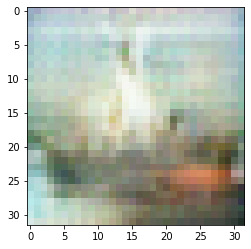

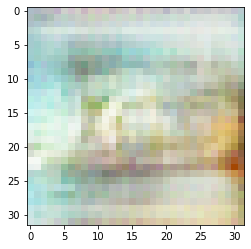

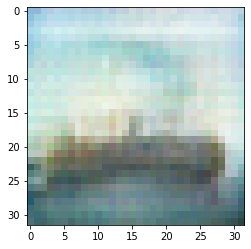

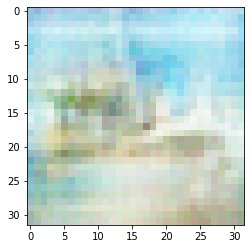

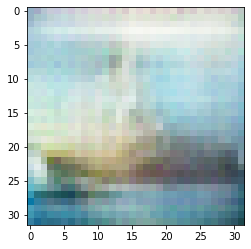

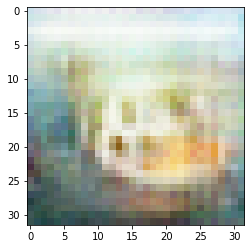

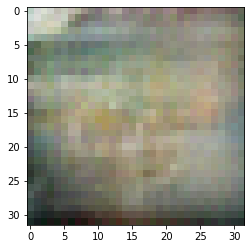

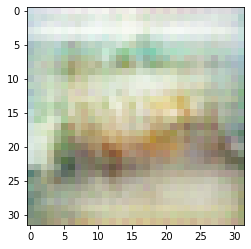

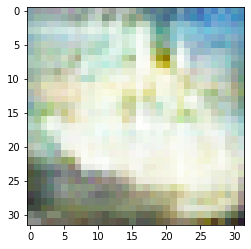

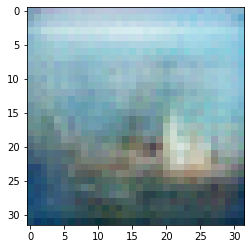

In [ ]:
import matplotlib.pyplot as plt

# Sample random points in the latent space
random_latent_vectors = np.random.normal(size=(10, latent_dim))

# Decode them to fake images
generated_images = generator.predict(random_latent_vectors)

for i in range(generated_images.shape[0]):
    img = image.array_to_img(generated_images[i] * 255., scale=False)
    plt.figure()
    plt.imshow(img)
    
plt.show()